<a href="https://colab.research.google.com/github/amrmoohamed/RLinTrading/blob/main/GP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Installation & Importing**

In [ ]:
# Install the unstable development version in Jupyter notebook:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!git clone https://github.com/AI4Finance-LLC/FinRL-Library.git
!pip install -r /content/FinRL-Library/requirements.txt

In [ ]:
!wget https://github.com/AI4Finance-LLC/FinRL-Library/files/5879628/env.zip

!unzip /content/env.zip

!cp /content/env/EnvMultipleStock_trade.py /usr/local/lib/python3.7/dist-packages/finrl/env
!cp /content/env/EnvMultipleStock_train.py /usr/local/lib/python3.7/dist-packages/finrl/env
!cp /content/env/environment.py /usr/local/lib/python3.7/dist-packages/finrl/env

In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4

In [ ]:
!pip install yahoo_fin
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_portfolio import StockPortfolioEnv
#from finrl.env.env_stocktrading import StockTradingEnv

from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats,get_baseline,trx_plot 

import sys
sys.path.append("../FinRL-Library")

from yahoo_fin import stock_info as si
from yahoo_fin.stock_info import get_data

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

#**Stock Screener**

In [ ]:
# Imports
from pandas_datareader import data as pdr
from yahoo_fin import stock_info as si
from pandas import ExcelWriter
import yfinance as yf
import pandas as pd
import datetime
import time
yf.pdr_override()

# Variables
tickers = si.tickers_sp500()
tickers = [item.replace(".", "-") for item in tickers] # Yahoo Finance uses dashes instead of dots
index_name = '^GSPC' # S&P 500
start_date = datetime.datetime.now() - datetime.timedelta(days=365)
end_date = datetime.date.today()
exportList = pd.DataFrame(columns=['Stock', "RS_Rating", "50 Day MA", "150 Day Ma", "200 Day MA", "52 Week Low", "52 week High"])
returns_multiples = []

In [ ]:
# Index Returns
index_df = pdr.get_data_yahoo(index_name, start_date, end_date)
index_df['Percent Change'] = index_df['Adj Close'].pct_change()
index_return = (index_df['Percent Change'] + 1).cumprod()[-1]

# Find top 30% performing stocks (relative to the S&P 500)
for ticker in tickers:
    # Download historical data as CSV for each stock (makes the process faster)
    df = pdr.get_data_yahoo(ticker, start_date, end_date)
    df.to_csv(f'{ticker}.csv')

    # Calculating returns relative to the market (returns multiple)
    df['Percent Change'] = df['Adj Close'].pct_change()
    stock_return = (df['Percent Change'] + 1).cumprod()[-1]
    
    returns_multiple = round((stock_return / index_return), 2)
    returns_multiples.extend([returns_multiple])
    
    print (f'Ticker: {ticker}; Returns Multiple against S&P 500: {returns_multiple}\n')
    time.sleep(1)

# Creating dataframe of only top 30%
rs_df = pd.DataFrame(list(zip(tickers, returns_multiples)), columns=['Ticker', 'Returns_multiple'])
rs_df['RS_Rating'] = rs_df.Returns_multiple.rank(pct=True) * 100
rs_df = rs_df[rs_df.RS_Rating >= rs_df.RS_Rating.quantile(.70)]

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multitasking/__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 170, in _download_one_threaded
    actions, period, interval, prepost, proxy, rounding)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/multi.py", line 185, in _download_one
    rounding=rounding, many=True)
  File "/usr/local/lib/python3.7/dist-packages/yfinance/base.py", line 157, in history
    data = data.json()
  File "/usr/local/lib/python3.7/dist-packages/requests/models.py", line 898, in json
    return complexjson.loads(self.text, **kwargs)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    ret

KeyboardInterrupt: ignored

In [ ]:
# Checking Minervini conditions of top 30% of stocks in given list
rs_stocks = rs_df['Ticker']
for stock in rs_stocks:    
    try:
        df = pd.read_csv(f'{stock}.csv', index_col=0)
        sma = [50, 150, 200]
        for x in sma:
            df["SMA_"+str(x)] = round(df['Adj Close'].rolling(window=x).mean(), 2)
        
        # Storing required values 
        currentClose = df["Adj Close"][-1]
        moving_average_50 = df["SMA_50"][-1]
        moving_average_150 = df["SMA_150"][-1]
        moving_average_200 = df["SMA_200"][-1]
        low_of_52week = round(min(df["Low"][-260:]), 2)
        high_of_52week = round(max(df["High"][-260:]), 2)
        RS_Rating = round(rs_df[rs_df['Ticker']==stock].RS_Rating.tolist()[0])
        
        try:
            moving_average_200_20 = df["SMA_200"][-20]
        except Exception:
            moving_average_200_20 = 0

        # Condition 1: Current Price > 150 SMA and > 200 SMA
        condition_1 = currentClose > moving_average_150 > moving_average_200
        
        # Condition 2: 150 SMA and > 200 SMA
        condition_2 = moving_average_150 > moving_average_200

        # Condition 3: 200 SMA trending up for at least 1 month
        condition_3 = moving_average_200 > moving_average_200_20
        
        # Condition 4: 50 SMA> 150 SMA and 50 SMA> 200 SMA
        condition_4 = moving_average_50 > moving_average_150 > moving_average_200
           
        # Condition 5: Current Price > 50 SMA
        condition_5 = currentClose > moving_average_50
           
        # Condition 6: Current Price is at least 30% above 52 week low
        condition_6 = currentClose >= (1.3*low_of_52week)
           
        # Condition 7: Current Price is within 25% of 52 week high
        condition_7 = currentClose >= (.75*high_of_52week)
        
        # If all conditions above are true, add stock to exportList
        if(condition_1 and condition_2 and condition_3 and condition_4 and condition_5 and condition_6 and condition_7):
            exportList = exportList.append({'Stock': stock, "RS_Rating": RS_Rating ,"50 Day MA": moving_average_50, "150 Day Ma": moving_average_150, "200 Day MA": moving_average_200, "52 Week Low": low_of_52week, "52 week High": high_of_52week}, ignore_index=True)
            print (stock + " made the Minervini requirements")
    except Exception as e:
        print (e)
        print(f"Could not gather data on {stock}")

exportList = exportList.sort_values(by='RS_Rating', ascending=False)
print('\n', exportList)
writer = ExcelWriter("ScreenOutput.xlsx")
exportList.to_excel(writer, "Sheet1")
writer.save()

In [ ]:
df =pd.read_excel('ScreenOutput.xlsx')
df.shape

In [ ]:
df.head()

In [ ]:
stockslist = df['Stock'].unique()

#**Data preparaing**

##**Setup period and gathering data**

In [ ]:
yeartoday = 365
years = 7
start_date = datetime.datetime.now() - datetime.timedelta(days= years*yeartoday)
start_date = str(start_date)[:10]
end_date = datetime.date.today()
end_date = str(end_date)

In [ ]:
stockslist = list(stockslist)
print(stockslist)

##**stocks with enough historical data**

In [ ]:
for t in stockslist:
  df = get_data(t,start_date,end_date,index_as_date = True, interval="1d")
  df.dropna(axis=0,inplace=True)
  df.to_csv(f'{t}.csv')

In [ ]:
df_G = get_data('GOOGL',start_date,end_date, interval="1d")
biggestdf = df_G.shape[0]

In [ ]:
for t in stockslist:
  data = pd.read_csv(f'{t}.csv', index_col=0)
  datasize = data.shape[0]
  if datasize != biggestdf:
    stockslist.remove(t)
  else:
    pass
    #tenactivesymbolls = tenactivesymbols

In [ ]:
#tickers.remove('F')

In [ ]:
print(stockslist)

In [ ]:
len(stockslist)

In [ ]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = stockslist).fetch_data()

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

#**Feautre pipeline**

In [ ]:
#tech_indicator_list=config.TECHNICAL_INDICATORS_LIST
## you can add more technical indicators
## visit https://github.com/jealous/stockstats for different names

tech_indicator_list=config.TECHNICAL_INDICATORS_LIST

In [ ]:
tech_indicator_list.remove('cci_30')

In [ ]:
print(tech_indicator_list)

In [ ]:
tech_indicator_list = tech_indicator_list +['dma','trix','open_30_sma','open_60_sma']

In [ ]:
print(tech_indicator_list)

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=True,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

In [ ]:
df.shape

In [ ]:
df.head()

##**Add covariance matrix as states**

In [ ]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [ ]:
df.shape

In [ ]:
df.describe()

In [ ]:
df.head()

#**Design Environment**

##**Class**

In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

#**ENV**

In [ ]:
#when add Covariance Matrix
trainsize = 0.8

start_date_after_cov = pd.to_datetime(start_date) + datetime.timedelta(days=365)
start_train = str(start_date_after_cov)[:10]

Interval = pd.to_datetime(end_date) - pd.to_datetime(start_date_after_cov)
train_Interval = trainsize * Interval

end_train = start_date_after_cov + datetime.timedelta(days= train_Interval.days)
end_train = str(end_train)[:10]
end_trade = pd.to_datetime(end_date)
end_trade = str(end_trade)[:10]

#start_train = str(start_date)[:10]

In [ ]:
#when not add Covariance Matrix

trainsize = 0.9

start_train = str(start_date)[:10]

Interval = pd.to_datetime(end_date) - pd.to_datetime(start_date)
train_Interval = trainsize * Interval

end_train = pd.to_datetime(start_date) + datetime.timedelta(days= train_Interval.days)
end_train = str(end_train)[:10]
end_trade = pd.to_datetime(end_date)
end_trade = str(end_trade)[:10]

In [ ]:
train = data_split(df, start = start_train, end = end_train)
trade = data_split(df, start = end_train, end = end_trade)

In [ ]:
train.head(2)

##**Environment for Portfolio Allocation**

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
#state_space = 1 + 2*stock_dimension + len(tech_indicator_list)*stock_dimension
#state_space = 1 + 2*(stock_dimension+2) + (len(tech_indicator_list)-2)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

In [ ]:
env_kwargs = {
    "hmax": 1000,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001, 
    #"buy_cost_pct": 0.001,
    #"sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

#**DRL Algorithms**

In [ ]:
from finrl.trade.backtest import backtest_plot,convert_daily_return_to_pyfolio_ts,get_daily_return
from pyfolio import timeseries
import pyfolio

In [ ]:
# initialize
agent = DRLAgent(env = env_train)

In [ ]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [ ]:
env_trade, _ = e_train_gym.get_sb_env()
print(type(env_trade))

##**A2C**

###**Train**

In [ ]:
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0001}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0001}
Using cuda device
Logging to tensorboard_log/a2c/a2c_6
------------------------------------
| time/                 |          |
|    fps                | 229      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -70.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0001   |
|    n_updates          | 99       |
|    policy_loss        | 2.78e+08 |
|    std                | 0.999    |
|    value_loss         | 1.95e+13 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 226       |
|    iterations         | 200       |
|    time_elapsed       | 4         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -70.9     |
|    explained_variance | -

###**Trade**

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:2382807.6492726854
Sharpe:  3.0705050245366854
hit end!


In [ ]:
df_daily_return.head(2)

date  daily_return
0  2020-04-27       0.00000
1  2020-04-28       0.01569

In [ ]:
df_actions.head(2)

A       ALB      ALGN  ...      WELL       XYL      ZBRA
date                                      ...                              
2020-04-27  0.020000  0.020000  0.020000  ...  0.020000  0.020000  0.020000
2020-04-28  0.033996  0.033996  0.026095  ...  0.033996  0.013901  0.027664

[2 rows x 50 columns]

###**BackTest**

In [ ]:
#baseline_df['daily_return'] = list(get_daily_return(baseline_df, value_col_name="close"))
#baseline_return = pd.Series(data=baseline_df['daily_return'], index=baseline_df['date'].astype('datetime64'))
#daily_return = pd.Series(data=list(df_daily_return['daily_return'].astype('float64')), index=baseline_df['date'].astype('datetime64'))

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat, 
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

print("==============A2C Strategy Stats===========")
perf_stats_all

==============A2C Strategy Stats===========


Annual return          1.058821
Cumulative returns     1.382808
Annual volatility      0.245292
Sharpe ratio           3.070505
Calmar ratio           7.766427
Stability              0.977314
Max drawdown          -0.136333
Omega ratio            1.703939
Sortino ratio          4.860551
Skew                  -0.274007
Kurtosis               3.221616
Tail ratio             1.141121
Daily value at risk   -0.027915
Alpha                  0.000000
Beta                   1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (303, 8)
==============Compare to 	Dow 30===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


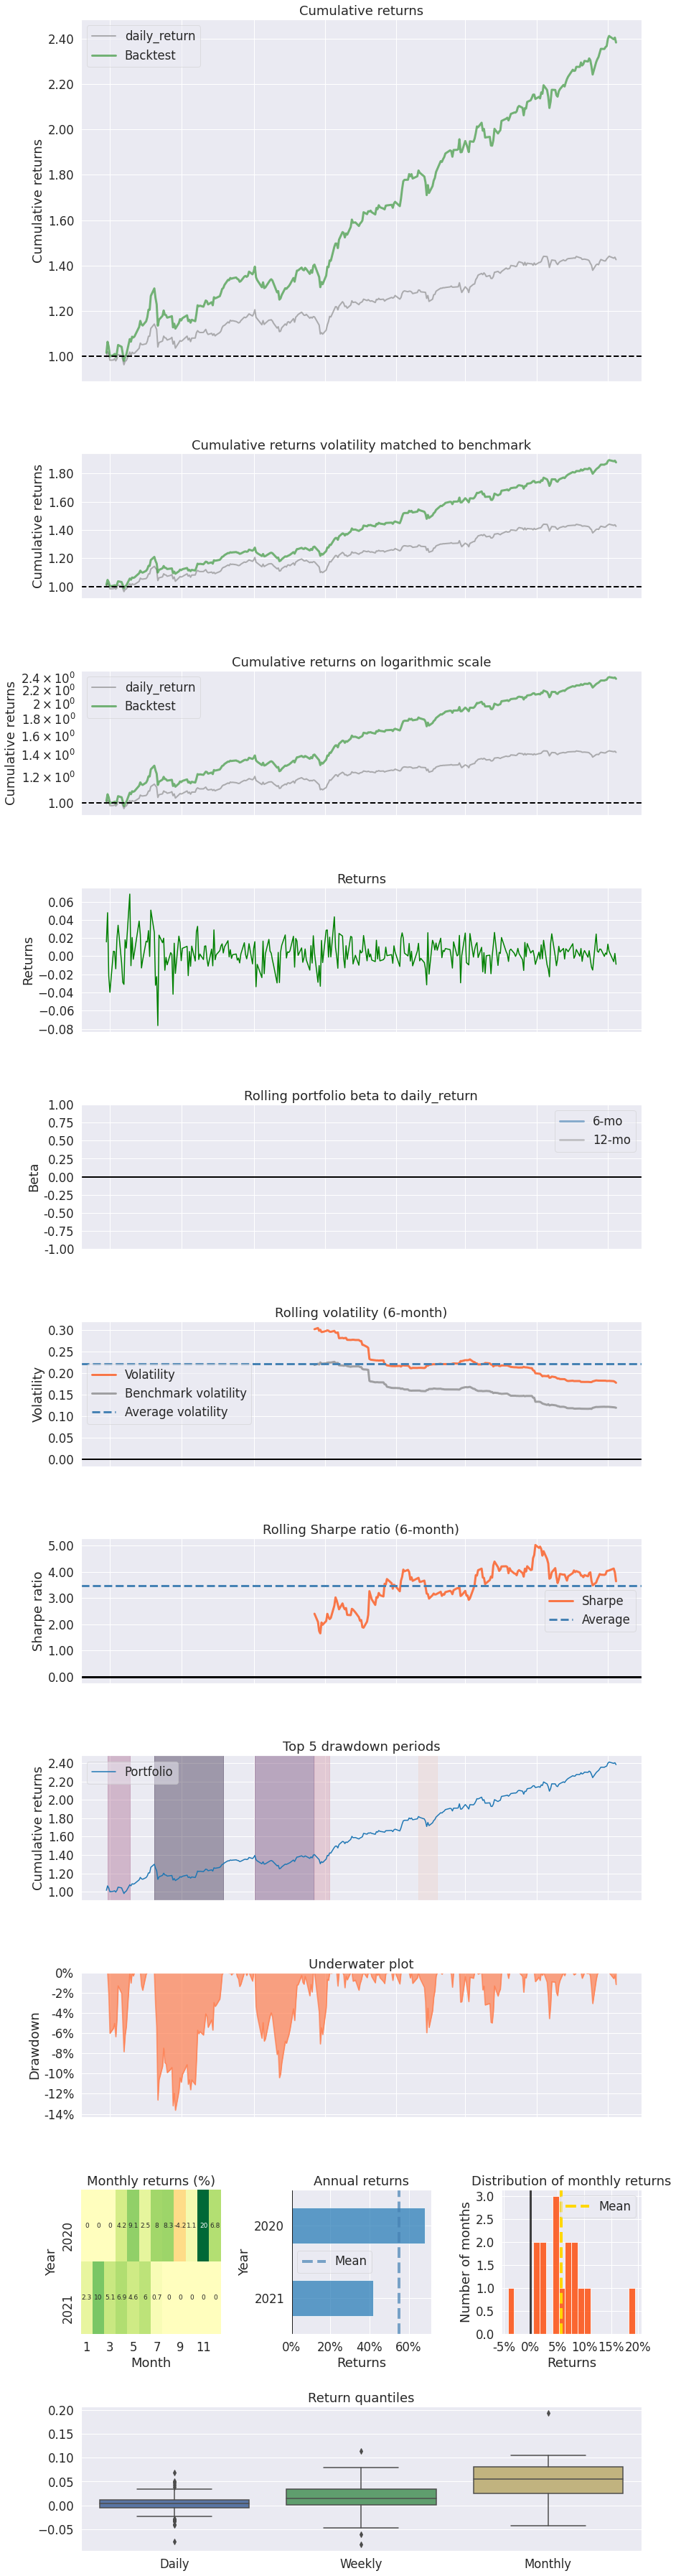

In [ ]:
baseline_df = get_baseline(
        ticker='^DJI', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to 	Dow 30===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (303, 8)
==============Compare to S&P 500===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


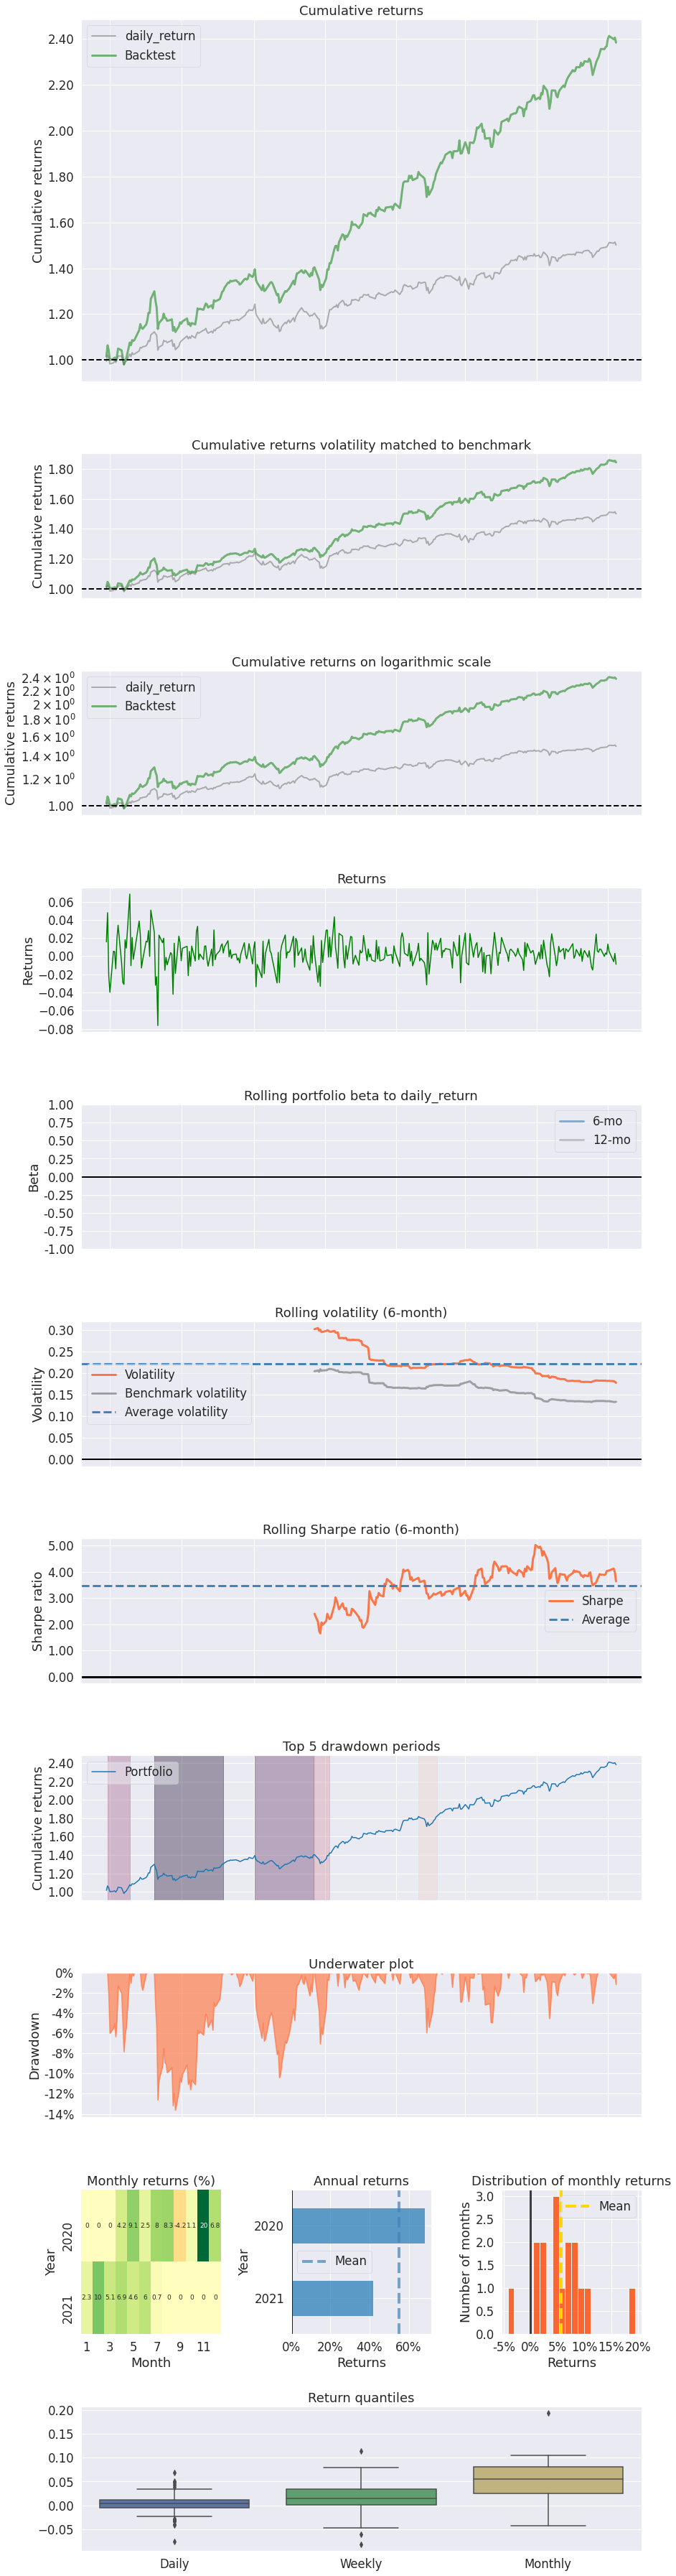

In [ ]:
baseline_df = get_baseline(
        ticker='^GSPC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to S&P 500===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (303, 8)
==============Compare to Nasdaq===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


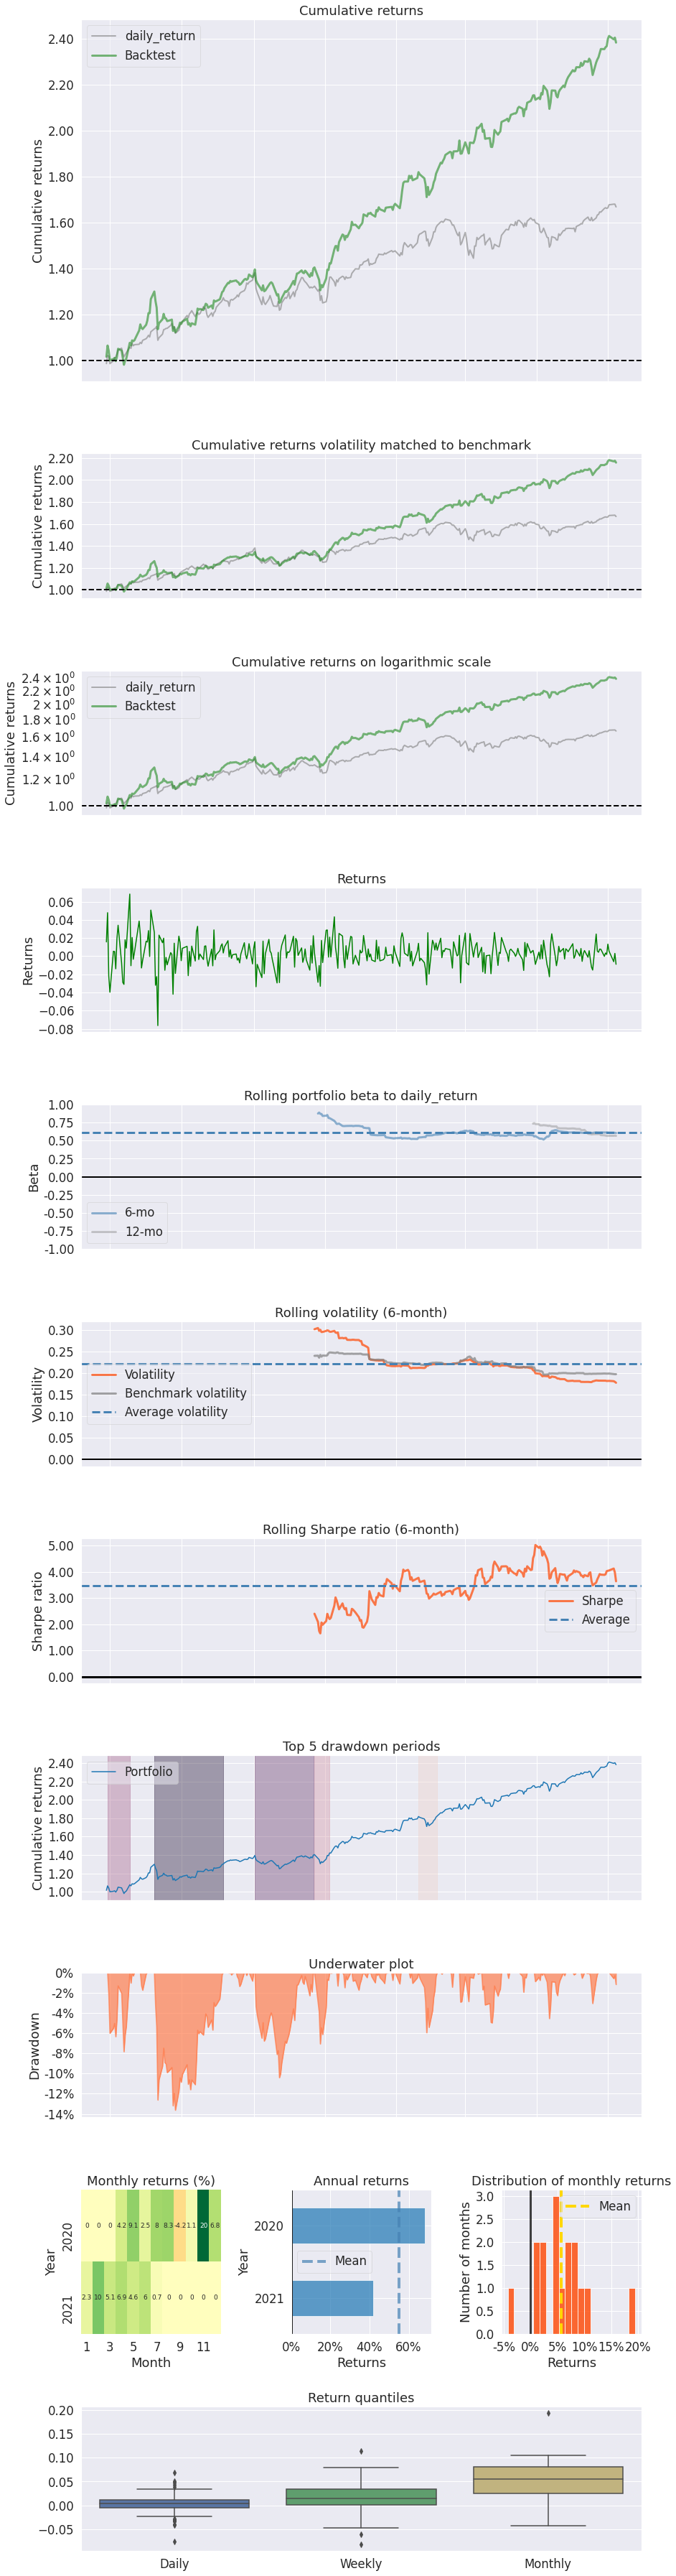

In [ ]:
baseline_df = get_baseline(
        ticker='^IXIC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline

print("==============Compare to Nasdaq===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

##**DDPG**

###**Train**

In [ ]:
DDPG_PARAMS = {"batch_size": 64, "buffer_size": 50000, "learning_rate": 0.0001}
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

###**Trade**

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg,environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:2052677.3649890802
Sharpe:  1.327298330666449
hit end!


###**Backtest**

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat, 
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

print("==============DDPG Strategy Stats===========")
perf_stats_all

==============DDPG Strategy Stats===========


Annual return           0.493227
Cumulative returns      1.052677
Annual volatility       0.348542
Sharpe ratio            1.327298
Calmar ratio            1.094459
Stability               0.720306
Max drawdown           -0.450658
Omega ratio             1.312001
Sortino ratio           1.863467
Skew                   -0.737651
Kurtosis               11.630232
Tail ratio              0.844729
Daily value at risk    -0.042076
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (452, 8)
==============Compare to 	Dow 30===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


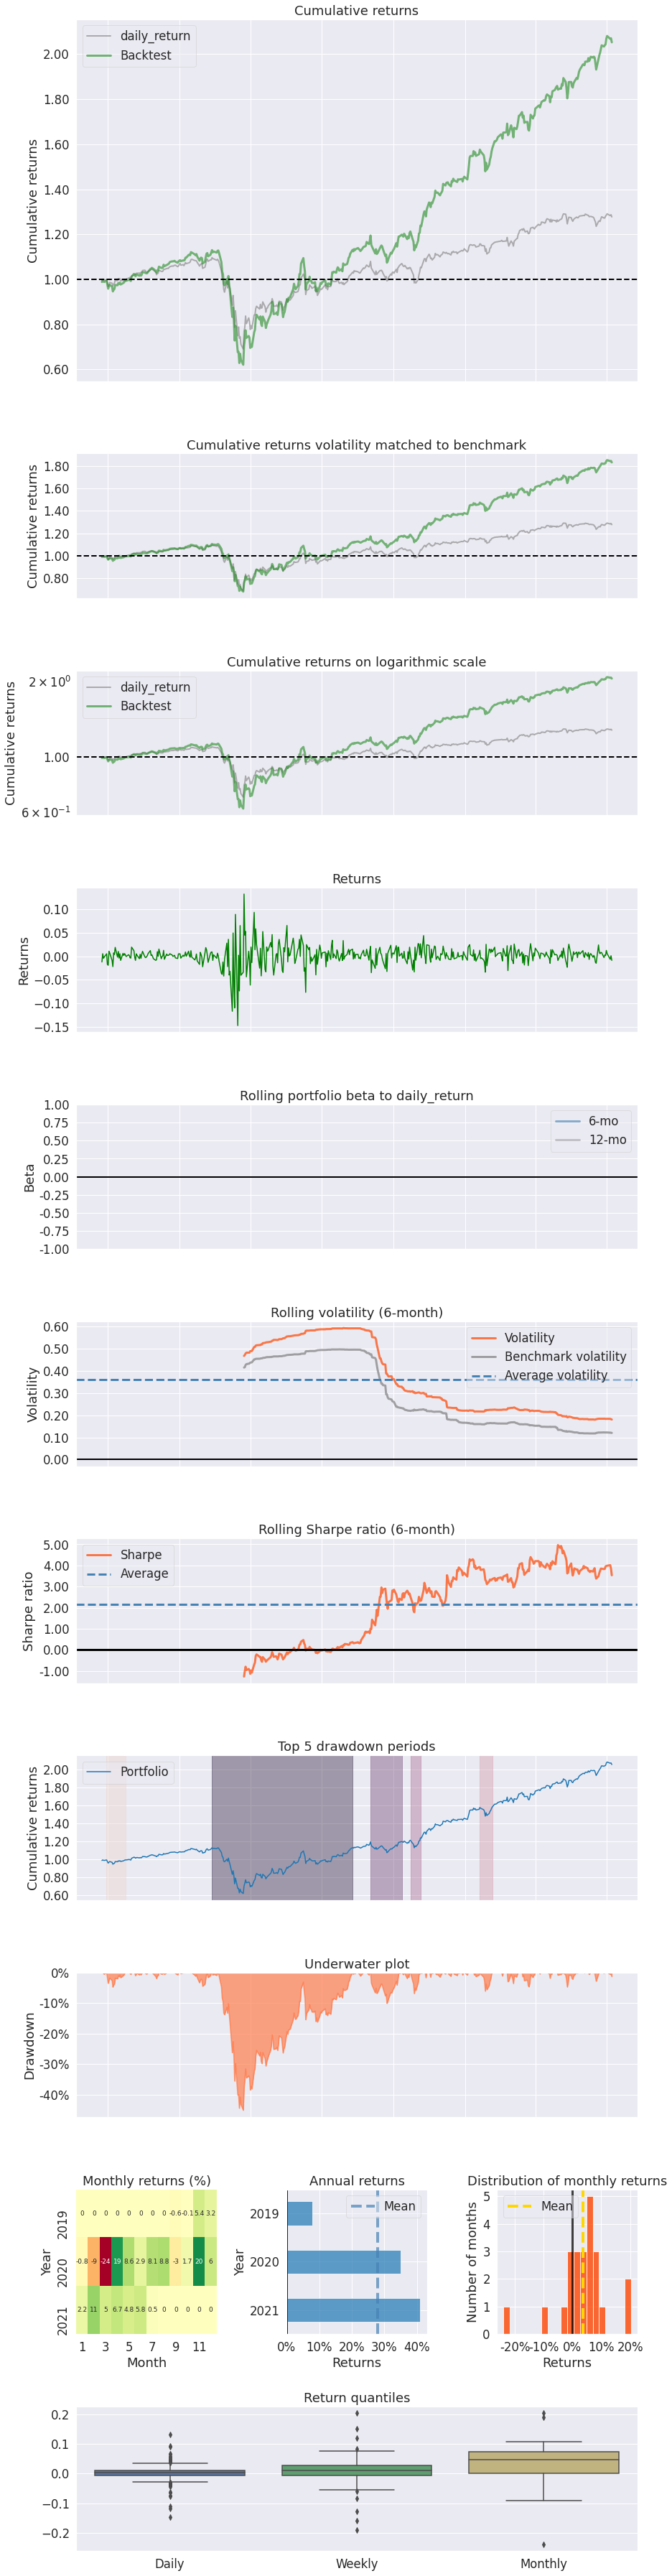

In [ ]:
baseline_df = get_baseline(
        ticker='^DJI', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to 	Dow 30===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

In [ ]:
baseline_df = get_baseline(
        ticker='^GSPC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to S&P 500===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

In [ ]:
baseline_df = get_baseline(
        ticker='^IXIC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline

print("==============Compare to Nasdaq===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

##**PPO**

###**Train**

In [ ]:
PPO_PARAMS = {
    "n_steps": 5,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:138: UserWarning: You have specified a mini-batch size of 128, but because the `RolloutBuffer` is of size `n_steps * n_envs = 5`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 5
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=5 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    fps                  | 50          |
|    iterations           | 9738        |
|    time_elapsed         | 962         |
|    total_timesteps      | 48690       |
| train/                  |             |
|    approx_kl            | 8.34465e-08 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -71         |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0001      |
|    loss                 | 7.99e+12    |
|    n_updates            | 97370       |
|    policy_gradient_loss | -0.000135   |
|    std                  | 1           |
|    value_loss           | 1.6e+13     |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 9739         |
|    time_elapsed         | 962          |
|    total_timesteps

###**Trade**

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:2404666.4883370497
Sharpe:  3.146099653269316
hit end!


###**Backtest**

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat, 
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

print("==============PPO Strategy Stats===========")
perf_stats_all

==============PPO Strategy Stats===========


Annual return          1.074517
Cumulative returns     1.404666
Annual volatility      0.241528
Sharpe ratio           3.146100
Calmar ratio           8.238411
Stability              0.978894
Max drawdown          -0.130428
Omega ratio            1.723326
Sortino ratio          4.990594
Skew                  -0.279117
Kurtosis               2.865762
Tail ratio             1.065876
Daily value at risk   -0.027414
Alpha                  0.000000
Beta                   1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (303, 8)
==============Compare to 	Dow 30===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


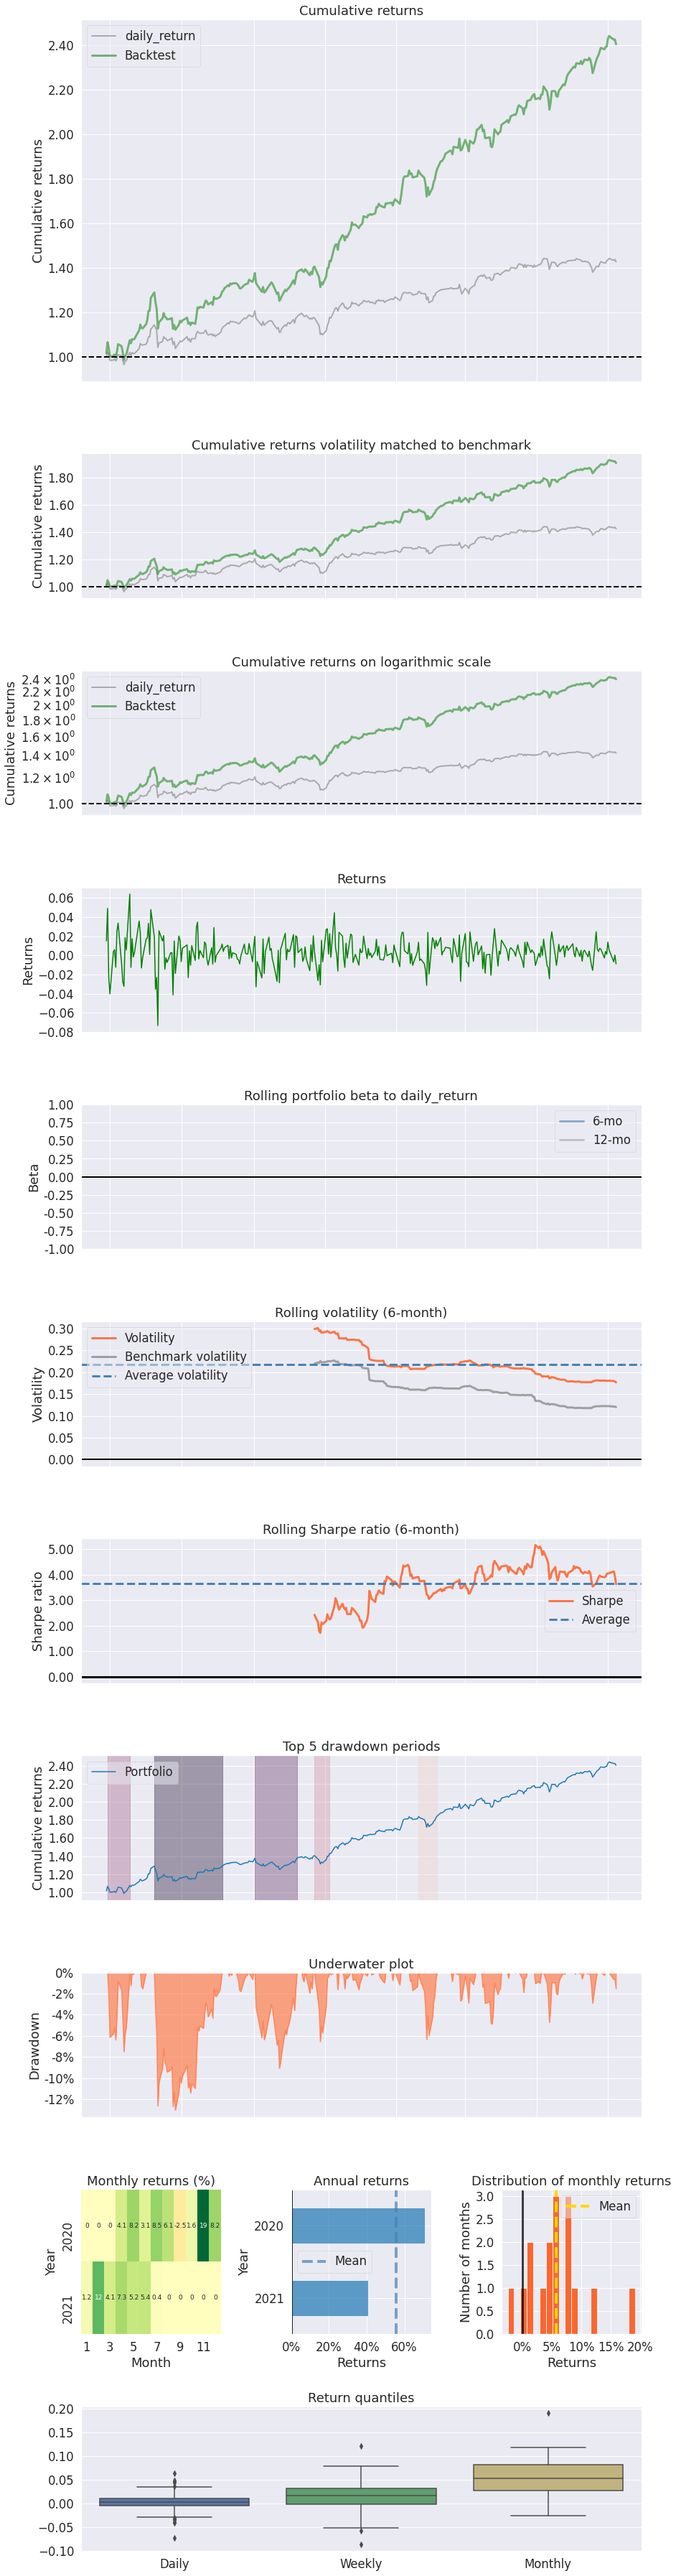

In [ ]:
baseline_df = get_baseline(
        ticker='^DJI', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to 	Dow 30===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (303, 8)
==============Compare to S&P 500===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


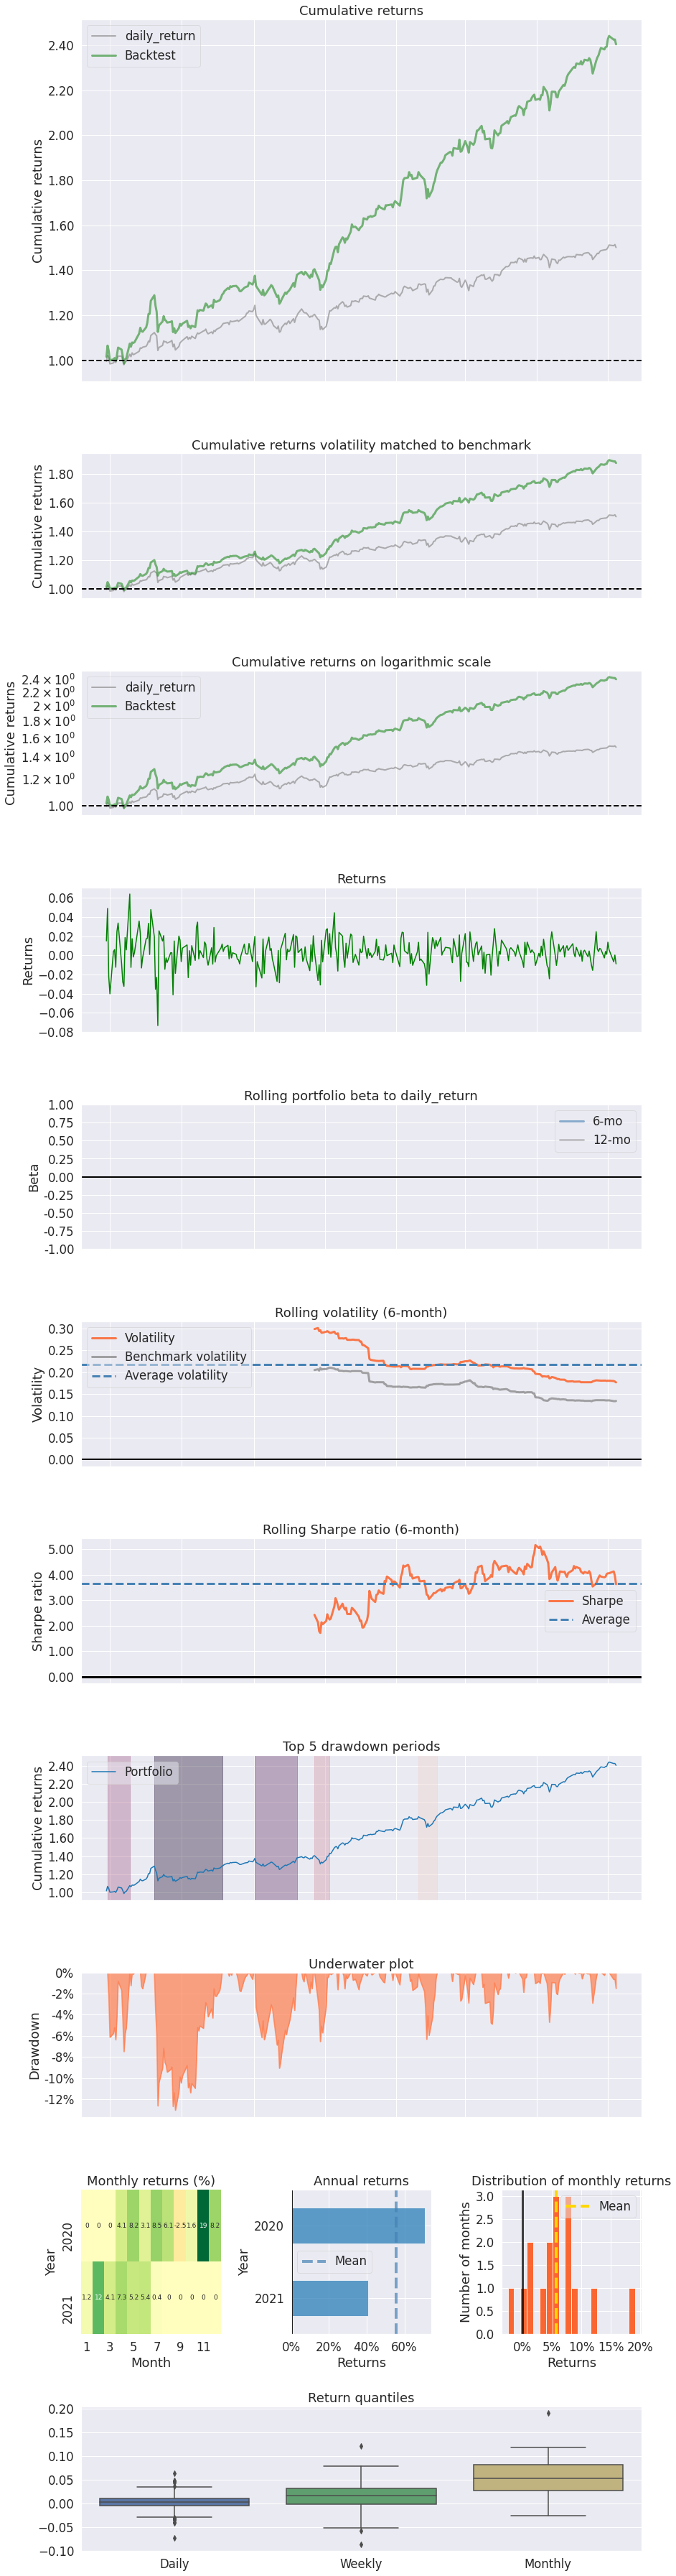

In [ ]:
baseline_df = get_baseline(
        ticker='^GSPC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to S&P 500===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (303, 8)
==============Compare to Nasdaq===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


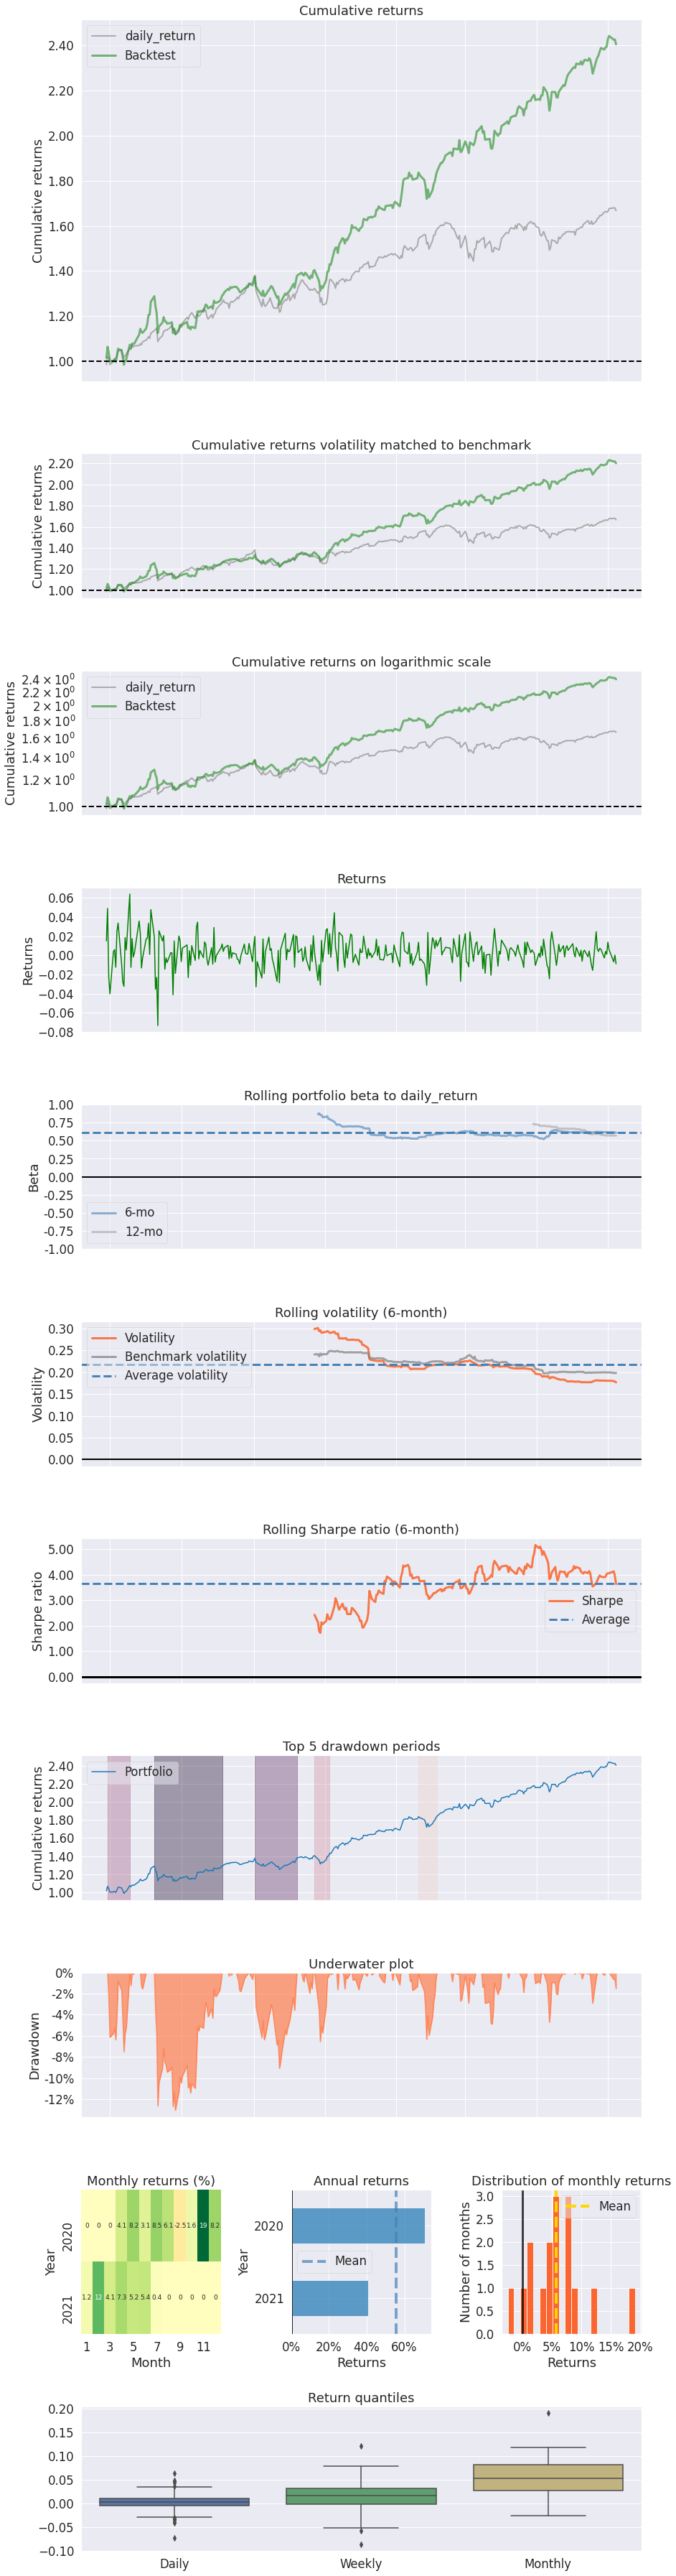

In [ ]:
baseline_df = get_baseline(
        ticker='^IXIC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline

print("==============Compare to Nasdaq===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

##**TD3**

###**Train**

In [ ]:
TD3_PARAMS = {"batch_size": 64, 
              "buffer_size": 50000, 
              "learning_rate": 0.0001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000)

{'batch_size': 64, 'buffer_size': 50000, 'learning_rate': 0.0001}
Using cuda device
Logging to tensorboard_log/td3/td3_1
begin_total_asset:1000000
end_total_asset:1607993.8796119306
Sharpe:  0.555264511040352
begin_total_asset:1000000
end_total_asset:1659957.7836485126
Sharpe:  0.5818339259410379
begin_total_asset:1000000
end_total_asset:1659957.7836485126
Sharpe:  0.5818339259410379
begin_total_asset:1000000
end_total_asset:1659957.7836485126
Sharpe:  0.5818339259410379
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 85        |
|    time_elapsed    | 56        |
|    total timesteps | 4824      |
| train/             |           |
|    actor_loss      | -7.84e+06 |
|    critic_loss     | 1.08e+11  |
|    learning_rate   | 0.0001    |
|    n_updates       | 3618      |
----------------------------------
begin_total_asset:1000000
end_total_asset:1659957.7836485126
Sharpe:  0.5818339259410379
begin_total_ass

###**Trade**

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_td3,environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:2321003.569876157
Sharpe:  3.1129634417208916
hit end!


###**Backtest**

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat, 
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

print("==============TD3 Strategy Stats===========")
perf_stats_all

==============TD3 Strategy Stats===========


Annual return          1.014310
Cumulative returns     1.321004
Annual volatility      0.234066
Sharpe ratio           3.112963
Calmar ratio           7.901482
Stability              0.980532
Max drawdown          -0.128370
Omega ratio            1.715591
Sortino ratio          4.817007
Skew                  -0.541479
Kurtosis               3.592276
Tail ratio             1.075248
Daily value at risk   -0.026598
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [ ]:
baseline_df = get_baseline(
        ticker='^DJI', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to 	Dow 30===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

In [ ]:
baseline_df = get_baseline(
        ticker='^GSPC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to S&P 500===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

In [ ]:
baseline_df = get_baseline(
        ticker='^IXIC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline

print("==============Compare to Nasdaq===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

##**SAC**

###**Train**

In [ ]:
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to tensorboard_log/sac/sac_1
begin_total_asset:1000000
end_total_asset:1422355.6062099494
Sharpe:  0.4326954706037328
begin_total_asset:1000000
end_total_asset:1380482.0464799323
Sharpe:  0.4047618813291185
begin_total_asset:1000000
end_total_asset:1380323.0354999935
Sharpe:  0.4046577233262325
begin_total_asset:1000000
end_total_asset:1380328.7761172059
Sharpe:  0.40466122871079746
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 42        |
|    time_elapsed    | 114       |
|    total timesteps | 4824      |
| train/             |           |
|    actor_loss      | -1.99e+07 |
|    critic_loss     | 2.84e+12  |
|    ent_coef        | 0.167     |
|    ent_coef_loss   | 631       |
|    learning_rate   | 0.0001    |
|    n_updates       | 4723      |
-----------------

###**Trade**

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:2381261.2263706527
Sharpe:  3.003008043460484
hit end!


###**Backtest**

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat, 
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

print("==============SAC Strategy Stats===========")
perf_stats_all

==============SAC Strategy Stats===========


Annual return          1.057710
Cumulative returns     1.381261
Annual volatility      0.251107
Sharpe ratio           3.003008
Calmar ratio           7.331271
Stability              0.973708
Max drawdown          -0.144274
Omega ratio            1.685723
Sortino ratio          4.733139
Skew                  -0.294964
Kurtosis               2.949936
Tail ratio             1.145155
Daily value at risk   -0.028644
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [ ]:
baseline_df = get_baseline(
        ticker='^DJI', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to 	Dow 30===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

In [ ]:
baseline_df = get_baseline(
        ticker='^GSPC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to S&P 500===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

In [ ]:
baseline_df = get_baseline(
        ticker='^IXIC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline

print("==============Compare to Nasdaq===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)